In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [14]:
datagen = ImageDataGenerator(rescale=1./255,
                                      zoom_range=0.2,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      validation_split=0.2
                                      )
train_data = datagen.flow_from_directory('../content/drive/MyDrive/gaussian_filtered_images',
                                                     target_size=(224,224),
                                                     batch_size=32,
                                                     class_mode = 'categorical',
                                                     subset = 'training')

valid_data = datagen.flow_from_directory('../content/drive/MyDrive/gaussian_filtered_images',
                                                     target_size=(224,224),
                                                     batch_size=32,
                                                     class_mode = 'categorical',
                                                     subset = 'validation')
test_data = datagen.flow_from_directory(
    '../content/drive/MyDrive/gaussian_filtered_images', # Update with your test data path
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation' # Or a dedicated 'test' subset if you have one
)

Found 2947 images belonging to 5 classes.
Found 735 images belonging to 5 classes.
Found 735 images belonging to 5 classes.


In [15]:
!pip install -q efficientnet

In [16]:
import efficientnet.tfkeras as efn

In [17]:
def lr_rate(epoch,lr):
    if epoch<10:
        lr=0.0001
        return lr
    elif epoch<=15:
        lr=0.0005
        return lr
    elif epoch<=30:
        lr=0.0001
        return lr
    else:
        lr=lr*(epoch/(1+epoch))
        return lr
lr_callback=tf.keras.callbacks.LearningRateScheduler(lr_rate)

In [18]:
model = tf.keras.Sequential([
        efn.EfficientNetB0(
            input_shape=(224,224, 3),
            weights='imagenet',
            include_top=False
        ),tf.keras.layers.Flatten(),tf.keras.layers.Dense(5, activation='softmax')
    ])

model.compile(optimizer="Adam",loss='categorical_crossentropy',metrics=['acc'])

In [19]:
history = model.fit(
    train_data,
    validation_data=valid_data,
    callbacks=[lr_callback],
    epochs=40,
    verbose=1
)

Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


93/93 ━━━━━━━━━━━━━━━━━━━━ 161s 1s/step - acc: 0.5960 - loss: 1.2268 - val_acc: 0.5986 - val_loss: 1.0488 - learning_rate: 1.0000e-04
Epoch 2/40
93/93 ━━━━━━━━━━━━━━━━━━━━ 60s 610ms/step - acc: 0.7224 - loss: 0.7721 - val_acc: 0.6748 - val_loss: 0.9423 - learning_rate: 1.0000e-04
Epoch 3/40
93/93 ━━━━━━━━━━━━━━━━━━━━ 59s 604ms/step - acc: 0.7502 - loss: 0.6571 - val_acc: 0.7469 - val_loss: 0.7484 - learning_rate: 1.0000e-04
Epoch 4/40
93/93 ━━━━━━━━━━━━━━━━━━━━ 61s 610ms/step - acc: 0.7732 - loss: 0.5945 - val_acc: 0.7592 - val_loss: 0.7253 - learning_rate: 1.0000e-04
Epoch 5/40
93/93 ━━━━━━━━━━━━━━━━━━━━ 60s 617ms/step - acc: 0.8018 - loss: 0.5442 - val_acc: 0.7810 - val_loss: 0.6093 - learning_rate: 1.0000e-04
Epoch 6/40
93/93 ━━━━━━━━━━━━━━━━━━━━ 60s 610ms/step - acc: 0.8155 - loss: 0.4912 - val_acc: 0.7769 - val_loss: 0.5913 - learning_rate: 1.0000e-04
Epoch 7/40
93/93 ━━━━━━━━━━━━━━━━━━━━ 61s 613ms/step - acc: 0.8016 - loss: 0.4928 - val_acc: 0.7741 - val_loss: 0.5823 - learning_r

In [20]:
import matplotlib.pyplot as plt

In [21]:
def display_training_curves(training, validation, title, subplot):

    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

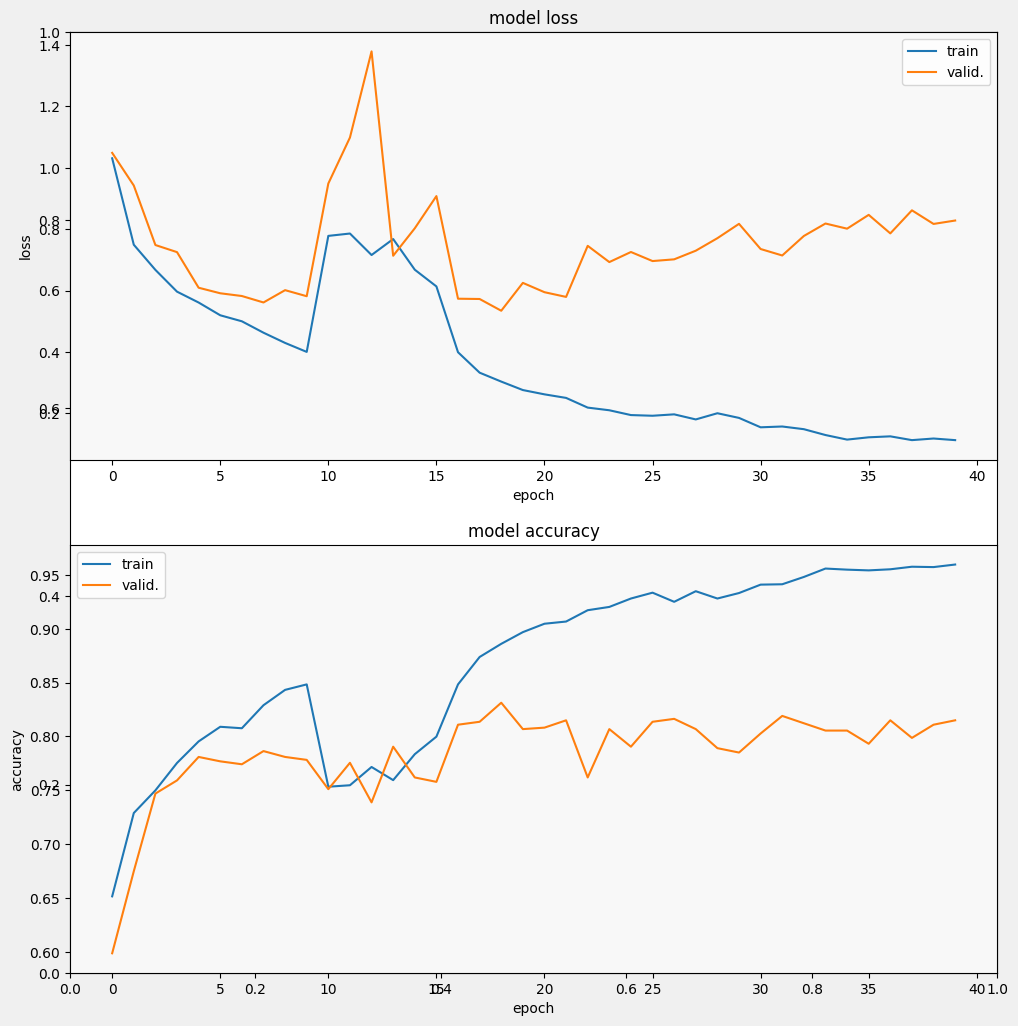

In [22]:
display_training_curves(
    history.history['loss'],
    history.history['val_loss'],
    'loss', 211)
display_training_curves(
    history.history['acc'],
    history.history['val_acc'],
    'accuracy', 212)

In [24]:
# Evaluate on the test set
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


23/23 ━━━━━━━━━━━━━━━━━━━━ 11s 499ms/step - acc: 0.8300 - loss: 0.7822
Test Accuracy: 82.86%


In [25]:
!pip install -q scikit-learn

In [26]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns


In [27]:
# Get predictions for the test data
y_pred = model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)

# Get the true labels for the test data
y_true = test_data.classes

23/23 ━━━━━━━━━━━━━━━━━━━━ 23s 725ms/step


In [28]:
cm = confusion_matrix(y_true, y_pred_classes)

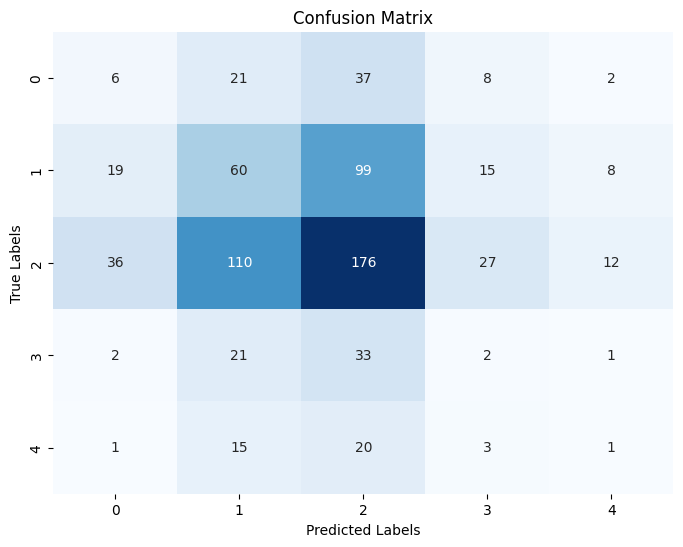

In [29]:
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()